# **Custom Knowledge ChatGPT with LangChain - Chat with PDFs**

**By Liam Ottley:**  [YouTube](https://youtube.com/@LiamOttley)

0.   Installs, Imports and API Keys
1.   PDF 로드 및 LangChain 청킹
2.   텍스트 임베딩 및 임베딩 저장
3.   검색 기능 생성
4.   채팅기록 저장

**google colab에서는 돌아가지 않습니다.**

# 0. Installs, Imports and API Keys

In [1]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
# RUN THIS CELL FIRST!
!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [ ]:
import os
import openai
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain
from dotenv import load_dotenv

In [ ]:
MODEL = "gpt-3.5-turbo"
load_dotenv(dotenv_path="../../.env.local") #.env.local에 openai.api_key가 저장되어 있음. 환경변수로 사용함.
openai.api_key=os.getenv("OPENAI_API_KEY")

# 1. PDF 로드 및 LangChain 청킹
- 이 노트북의 로컬 파일에 PDF를 추가해야 합니다

## 간단한 방법 - 페이지별로 분할

In [ ]:
loader = PyPDFLoader("./2023_GPT4All_Technical_Report.pdf")
pages = loader.load_and_split()
print(pages[0])

# 이 방법을 사용하는 경우 2단계로 건너뛰세요.
chunks = pages

page_content='GPT4All: Training an Assistant-style Chatbot with Large Scale Data\nDistillation from GPT-3.5-Turbo\nYuvanesh Anand\nyuvanesh@nomic.aiZach Nussbaum\nzanussbaum@gmail.com\nBrandon Duderstadt\nbrandon@nomic.aiBenjamin Schmidt\nben@nomic.aiAndriy Mulyar\nandriy@nomic.ai\nAbstract\nThis preliminary technical report describes the\ndevelopment of GPT4All, a chatbot trained\nover a massive curated corpus of assistant in-\nteractions including word problems, story de-\nscriptions, multi-turn dialogue, and code. We\nopenly release the collected data, data cura-\ntion procedure, training code, and final model\nweights to promote open research and repro-\nducibility. Additionally, we release quantized\n4-bit versions of the model allowing virtually\nanyone to run the model on CPU.\n1 Data Collection and Curation\nWe collected roughly one million prompt-\nresponse pairs using the GPT-3.5-Turbo OpenAI\nAPI between March 20, 2023 and March 26th,\n2023. To do this, we first gathered a d

## 고급 방법 - 청크로 분할

In [ ]:
# 1단계: PDF를 텍스트로 변환
import textract
doc = textract.process("./2023_GPT4All_Technical_Report.pdf")

# 2단계: .txt로 저장하고 다시 엽니다(문제 방지에 도움이 됨)
with open('2023_GPT4All_Technical_Report.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('2023_GPT4All_Technical_Report.txt', 'r') as f:
    text = f.read()

# 3단계: 토큰을 계산하는 함수 만들기
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# 4단계: 텍스트를 덩어리로 분할
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)
chunks = text_splitter.create_documents([text])

In [ ]:
# 결과는 약 500개 이하의 토큰으로 구성된 많은 LangChain '문서'입니다(재귀 분할기는 때때로 컨텍스트를 유지하기 위해 더 많은 토큰을 허용합니다).
type(chunks[0])

langchain.schema.Document

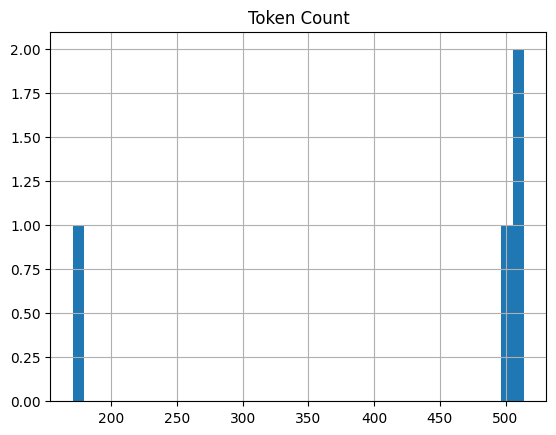

In [ ]:
# 청킹이 성공했는지 확인하기 위한 빠른 데이터 시각화
# 토큰 개수 목록을 생성합니다.
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# 토큰 수에서 DataFrame을 생성합니다.
df = pd.DataFrame({'Token Count': token_counts})

# 토큰 수 분포의 히스토그램을 만듭니다.
df.hist(bins=40, )

# 시각화
plt.show()

# 2. 텍스트 임베딩 및 임베딩 저장

In [ ]:
# 임베딩 모델 생성
embeddings = OpenAIEmbeddings()

# 벡터 데이터베이스 생성
db = FAISS.from_documents(chunks, embeddings)

# 3.   검색 기능 생성

In [ ]:
# 유사성 검색을 사용자 쿼리와 통합하기 위한 QA 체인 생성(지식 기반의 쿼리에 응답)
chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "트랜스포머를 만든 사람이 누구야?"
docs = db.similarity_search(query)
# 유사성 검색이 작동하는지 확인
print(docs[0])
chain.run(input_documents=docs, question=query)

page_content='Hugo Touvron, Thibaut Lavril, Gautier Izacard, Xavier\nMartinet, Marie-Anne Lachaux, Timoth´ee Lacroix,\nBaptiste Rozi`ere, Naman Goyal, Eric Hambro,\nFaisal Azhar, Aurelien Rodriguez, Armand Joulin,\nEdouard Grave, and Guillaume Lample. 2023.\nLlama: Open and efficient foundation language\nmodels.\n\nYizhong Wang, Yeganeh Kordi, Swaroop Mishra, Al-\nisa Liu, Noah A. Smith, Daniel Khashabi, and Han-\nnaneh Hajishirzi. 2022. Self-instruct: Aligning lan-\nguage model with self generated instructions.' metadata={}


' The authors of the Transformer model are Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin.'

# 4. 채팅 내용 리스트에 저장

In [ ]:
from IPython.display import display
import ipywidgets as widgets

# 벡터DB를 검색자로 사용하는 대화 체인을 생성합니다. 이를 통해 채팅 기록 관리도 가능합니다.
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [ ]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit': #대화 종료 조건
        print("Thank you for using the State of the Union chatbot!") #대화 종료 문구
        return

    #채팅 내용 저장
    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)
display(input_box)

Welcome to the Transformers chatbot! Type 'exit' to stop.


/var/folders/jh/dq2d4xj95557ckvt4cvkp7v00000gn/T/ipykernel_14692/390991004.py:21: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(on_submit)


Text(value='', placeholder='Please enter your question:')

HTML(value='<b>User:</b> 책의 저자가 누구야?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  책의 저자는 Yuvanesh Anand, Zach Nussbaum, Brandon Duderstad…

HTML(value='<b>User:</b> 초록 내용이 뭐야?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  본 책의 초록은 GPT4All 모델의 개발과 데이터 수집, 정제, 훈련 코드, 모델 가중치 및 정밀…

HTML(value='<b>User:</b> 결론은 뭐야?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  본 책의 결론은 GPT4All 모델 가중치와 데이터, 데이터 정리 절차, 훈련 코드 및 최종 모델 …

HTML(value='<b>User:</b> 평가 부분 요약해서 알려줘.')

HTML(value='<b><font color="blue">Chatbot:</font></b>  We performed a preliminary evaluation of our model usin…

HTML(value='<b>User:</b> 한글로 알려줄래?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  우리 모델은 외부에서 제공하는 최고의 alpaca-lora 모델과 비교해 작은 수의 작업에 대해 매…

Thank you for using the State of the Union chatbot!


In [ ]:
chat_history

[('책의 저자가 누구야?',
  ' 책의 저자는 Yuvanesh Anand, Zach Nussbaum, Brandon Duderstadt, Benjamin Schmidt, Andriy Mulyar 입니다.'),
 ('초록 내용이 뭐야?',
  ' 본 책의 초록은 GPT4All 모델의 개발과 데이터 수집, 정제, 훈련 코드, 모델 가중치 및 정밀화된 4 비트 버전 모델의 공개를 설명합니다.'),
 ('결론은 뭐야?',
  ' 본 책의 결론은 GPT4All 모델 가중치와 데이터, 데이터 정리 절차, 훈련 코드 및 최종 모델 가중치를 공개하여 열린 연구 및 재현성을 촉진하기 위해 배포하는 것을 목적으로 한다는 것입니다.'),
 ('평가 부분 요약해서 알려줘.',
  ' We performed a preliminary evaluation of our model using the human evaluation data from the Self-Instruct paper (Wang et al., 2022). We report the ground truth perplexity of our model against what is, to our knowledge, the best openly available alpaca-lora model, provided by user chainyo on huggingface. We find that all models have very large perplexities on a small number of tasks, and report perplexities clipped to a maximum of 100. Models finetuned on this collected dataset exhibit much lower perplexity in the Self-Instruct evaluation compared to Alpaca.'),
 ('한글로 알려줄래?',
  ' 우리 모델은 외부에서 제공하는 최고의 alpaca-lora 모델과 